In [ ]:
# !pip install "opencv-python-headless<4.3"
# !pip install cellpose
# !pip install scikit-image
# !pip install matplotlib
# !pip install gradio

In [1]:
SIZE = 96

In [2]:
!nvcc --version
!nvidia-smi

zsh:1: command not found: nvcc


Wed Oct 30 19:51:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:2B:00.0  On |                  N/A |
| 34%   46C    P3             27W /  170W |     834MiB /  12288MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Importa bibliotecas e verifica se a GPU está ativa

from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import utils, plot, models
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from PIL import Image
import os

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse;
from cellpose import models, core

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();


>>> GPU activated? 1
2024-10-30 19:54:14,282 [INFO] WRITING LOG OUTPUT TO /home/duardo/.cellpose/run.log
2024-10-30 19:54:14,282 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.12.6 
torch version:  	2.3.1+cu121


['ardidos1/Pic_2023_09_03_181912_1327.tiff', 'ardidos2/Pic_2023_09_03_182318_1334.tiff', 'ardidos3/Pic_2023_09_03_182407_1368.tiff', 'ardidos4/Pic_2023_09_03_183044_1449.tiff', 'ardidos5/Pic_2023_09_03_184327_1580.tiff', 'bandinhas1/Pic_2023_09_03_193428_2307.tiff', 'bandinhas2/Pic_2023_09_03_193546_2350.tiff', 'bandinhas3/Pic_2023_09_03_193716_2378.tiff', 'bandinhas4/Pic_2023_09_03_193854_2401.tiff', 'bandinhas5/Pic_2023_09_03_194014_2434.tiff', 'chochos1/Pic_2023_09_03_184652_1594.tiff', 'chochos2/Pic_2023_09_03_184903_1652.tiff', 'chochos3/Pic_2023_09_03_185530_1737.tiff', 'chochos4/Pic_2023_09_03_185935_1768.tiff', 'chochos5/Pic_2023_09_03_190200_1798.tiff', 'fermentados1/Pic_2023_09_03_191152_1911.tiff', 'fermentados2/Pic_2023_09_03_191324_1933.tiff', 'fermentados3/Pic_2023_09_03_191546_1968.tiff', 'fermentados4/Pic_2023_09_03_191822_1992.tiff', 'fermentados5/Pic_2023_09_03_192048_2037.tiff', 'imaturos1/Pic_2023_09_03_192426_2102.tiff', 'imaturos2/Pic_2023_09_03_192546_2145.tiff',

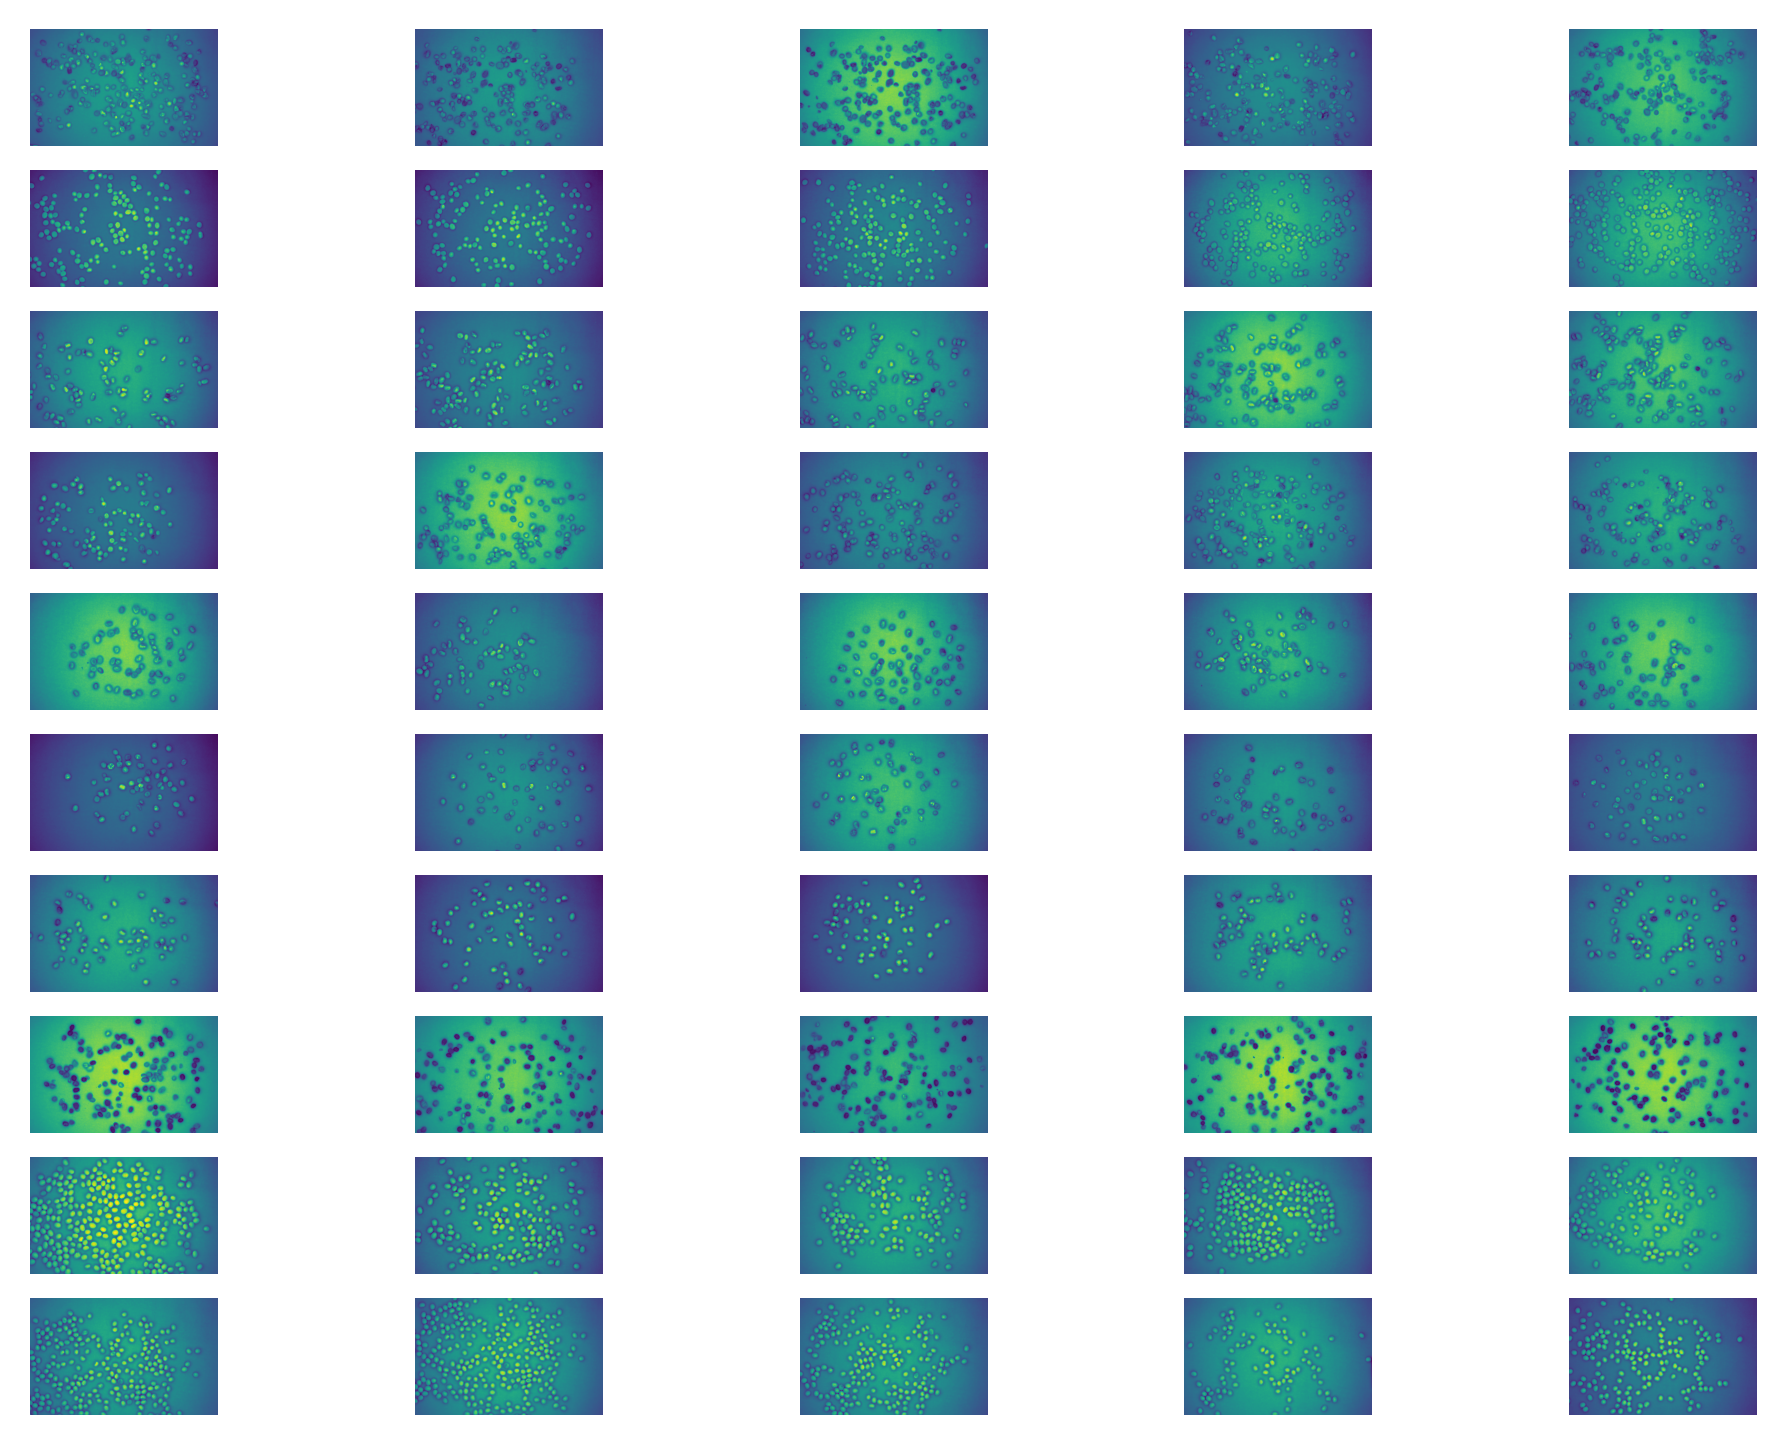

In [123]:
# Pasta raiz com as imagens de soja
image_folder_path = 'soja'

# Inicia vetor de arquivos 
files = []

# Percorre as pastas de imagens e seleciona um arquivo aleatório de cada pasta
# O objetivo de fazer isso é selecioanr uma imagem com um onda de luz aleatória e usa-la para a segmentação
folders = os.listdir(image_folder_path)
for folder in folders:
  # Pega todos os arquivos da pasta em ordem alfabética
  # E remove os dois primeiros arquivos que são uma captura que está tudo preto
  folder_path = os.path.join(image_folder_path, folder)
  _files = sorted(os.listdir(folder_path))
  _files = [f for f in _files[2:] if f.endswith('.tiff')] 

  if _files:
    # Seleciona um arquivo aleatório e adiciona no vetor de arquivos no formato 'pasta/arquivo'
    selected_file = random.choice(_files)
    files.append(os.path.join(folder, selected_file))

# Ordena os arquivos separados por pasta
files = sorted(files)

# files = files[:10]
print(files)
print(len(files))

# Utiliza a função imread do skimage para carregar as imagens
# A função imread carrega as imagens em um array numpy
# O array numpy é uma matriz com as dimensões da imagem e os valores dos pixels
imgs = [skimage.io.imread(os.path.join(image_folder_path, f)) for f in files]
nimg = len(imgs)
print(imgs[0].shape)


# Crio uma figura  10x5 para mostrar as imagens e visualizar se estão corretas
plt.figure(figsize=(8,6))
for k,img in enumerate(imgs):
   plt.subplot(10, 5 ,k+1)
   plt.axis('off')
   plt.imshow(img)
plt.savefig("amostras")

In [124]:
imgs_2D = imgs

# Carrega o modelo de segmentação Cellpose utilizando a GPU
# Com o model_type='cyto3' pois esse é o modelo mais generalista
model = models.Cellpose(gpu=use_GPU, model_type='cyto3')

# Define os canais de segmentação
# grayscale=0, R=1, G=2, B=3
# Se todas imagens forem do mesmo tipo, lista com 2 elementos
# channels = [0,0] # Para escala de cinza
channels = [0,0]

# Chama o modelo para analisar as imagens
# Diaemtro = 60 representa o tamanho médio dos grãos de soja
# flow_threshold = None representa que não há um threshold para o fluxo. Threshold é um valor que define o quanto de fluxo é necessário para considerar um objeto em movimento
masks, flows, styles, diams = model.eval(imgs_2D, diameter=60, flow_threshold=None, channels=channels)

# Tempo médio de execução para 50 imagens de 1920x1200 é de 40 segundos
# Ao final da execução, o modelo retorna as máscaras de segmentação, os fluxos e os estilos de segmentação e os diâmetros

2024-10-07 21:04:22,517 [INFO] ** TORCH CUDA version installed and working. **
2024-10-07 21:04:22,518 [INFO] >>>> using GPU
2024-10-07 21:04:22,518 [INFO] >> cyto3 << model set to be used
2024-10-07 21:04:22,559 [INFO] >>>> loading model /home/duardo/.cellpose/models/cyto3
2024-10-07 21:04:22,597 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-10-07 21:04:22,599 [INFO] channels set to [0, 0]
2024-10-07 21:04:22,599 [INFO] ~~~ FINDING MASKS ~~~
2024-10-07 21:05:00,948 [INFO] 100%|##########| 50/50 [00:38<00:00,  1.30it/s]
2024-10-07 21:05:00,948 [INFO] >>>> TOTAL TIME 38.35 sec


In [125]:
import string
def remove_numbers(s):
    return s.translate(str.maketrans('', '', string.digits))

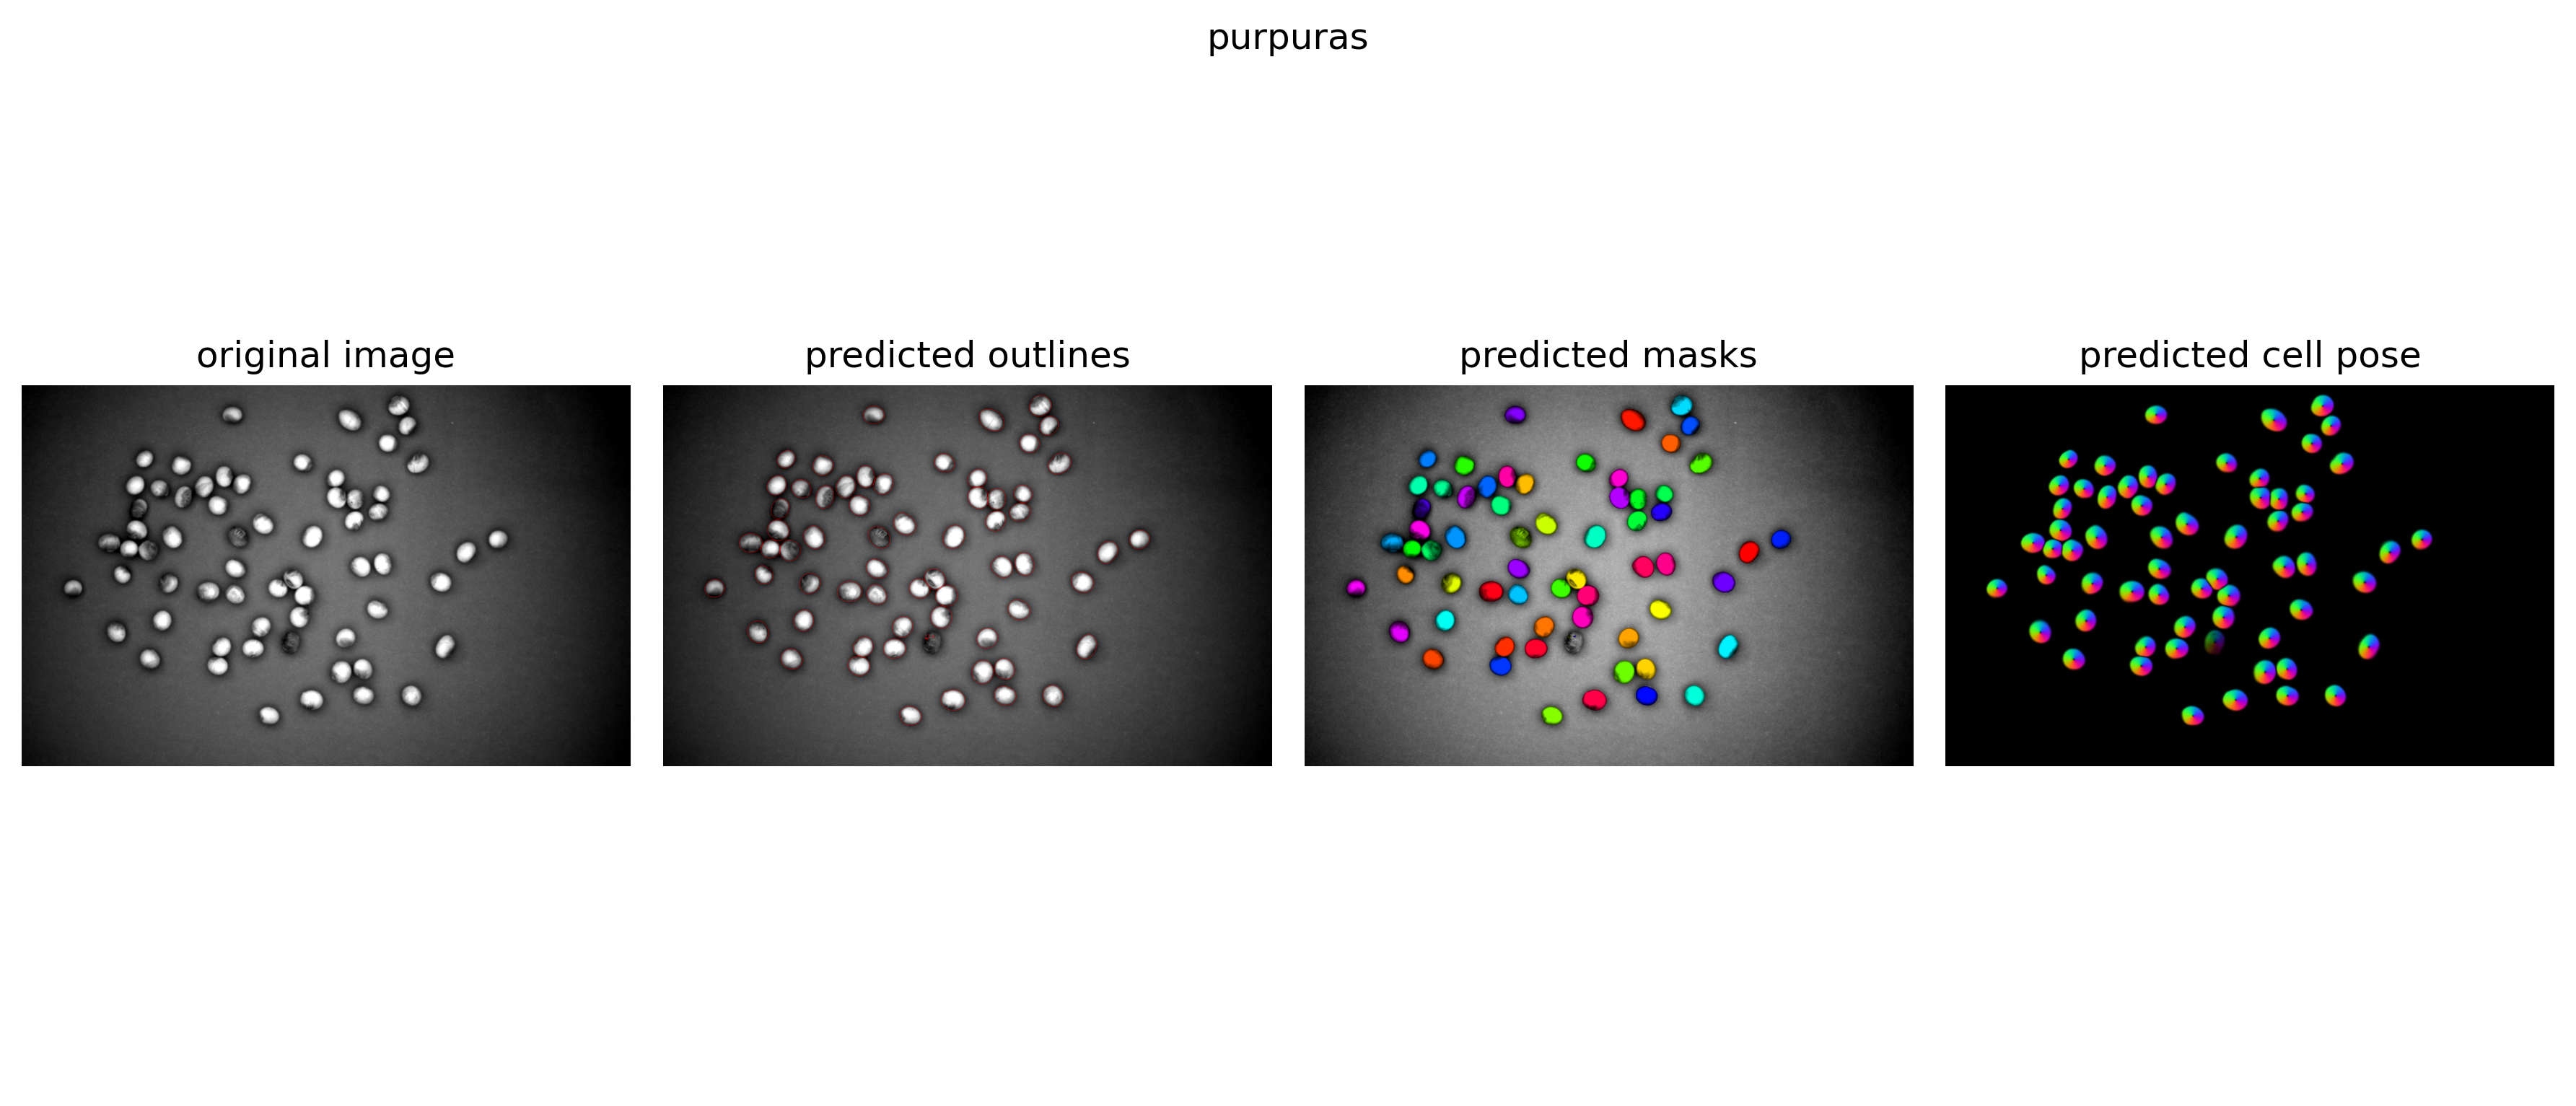

In [127]:

# Processo de visualização das imagens segmentadas
# Para cada imagem, é mostrado a imagem original, a máscara de segmentação e o fluxo de segmentação
nimg = len(imgs_2D)

idx = random.randint(0,nimg)

maski = masks[idx]
flowi = flows[idx][0]
file = files[idx]

label = remove_numbers(file.split('/')[0])

fig = plt.figure(figsize=(12,5))
plt.title(label)
plt.axis("off")
plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels, file_name=f"segmentacoes/segmentacao_{label}.png")
plt.tight_layout()
plt.show()

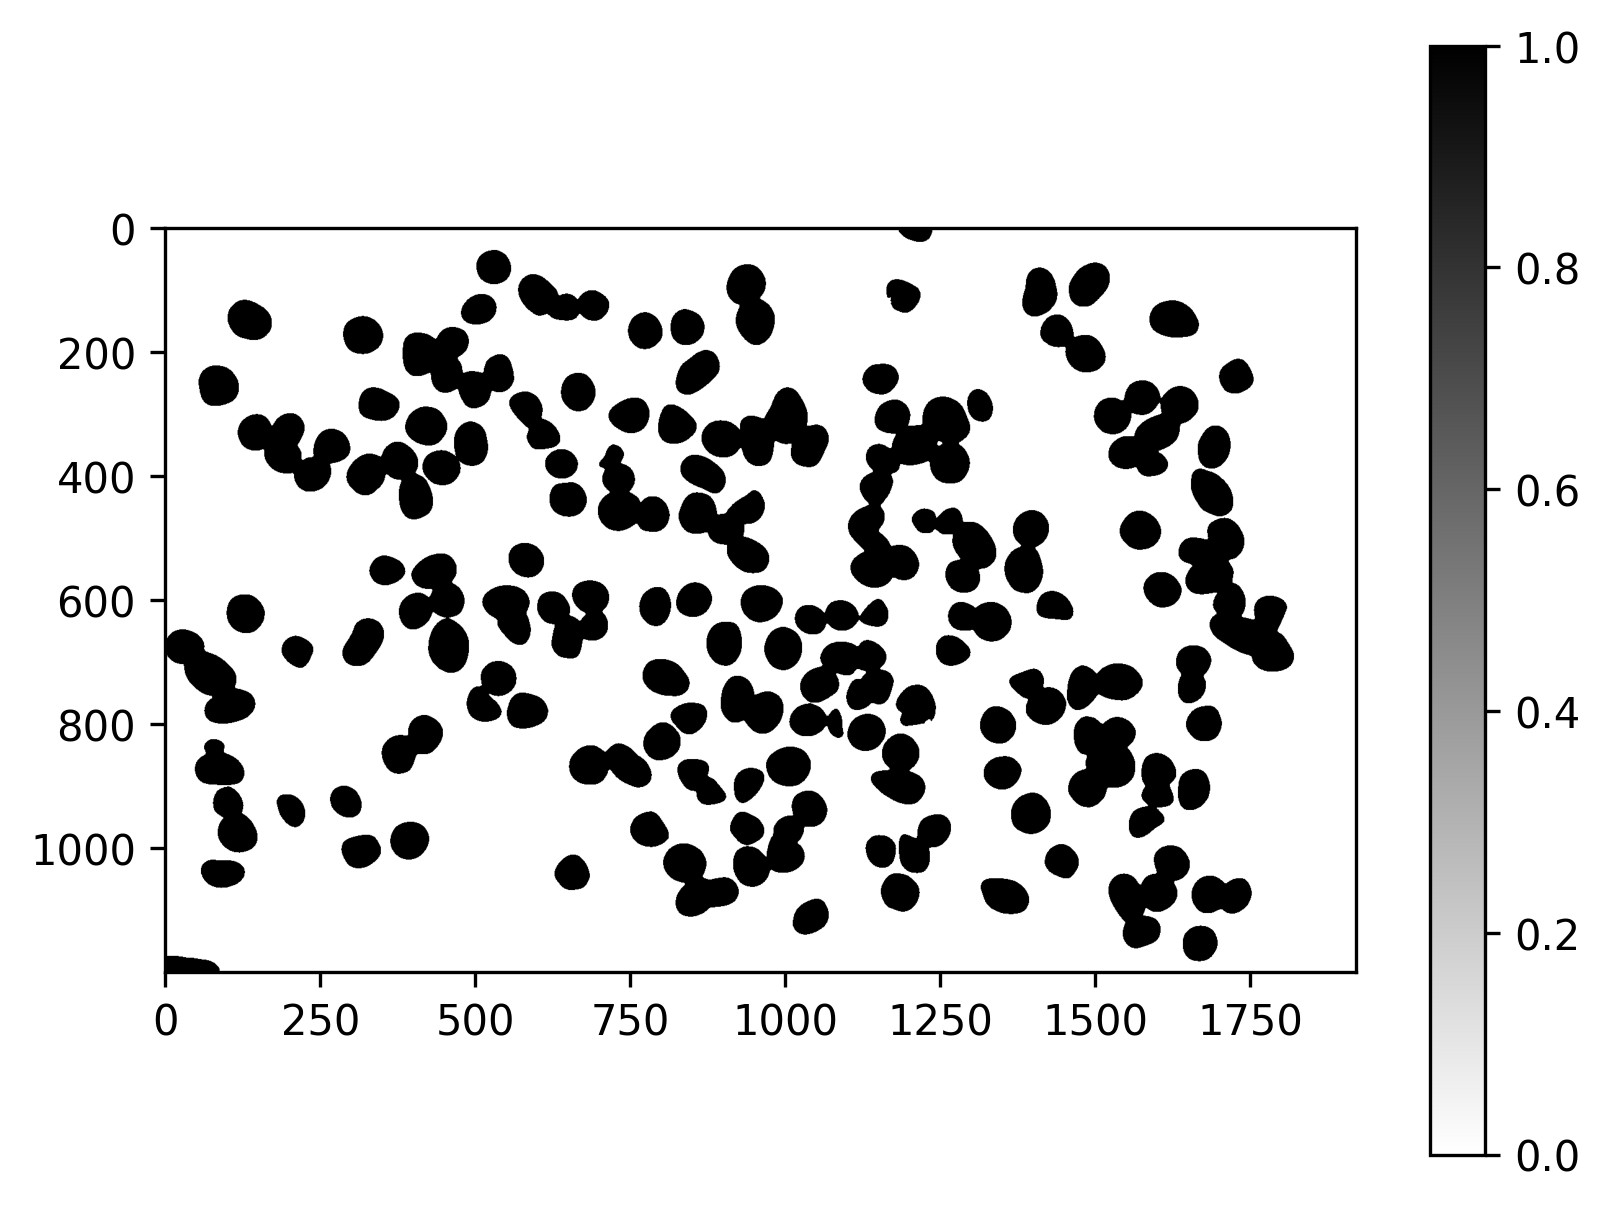

In [128]:
# Carrega a imagem original e a máscara
image = imgs[idx] 
mask = masks[idx]  

binary_mask = (masks[0] > 0).astype(int)

# Exibe a máscara binária
plt.imshow(binary_mask, cmap='binary') 
plt.colorbar()
plt.show()


In [129]:

nimg = len(imgs_2D)

# Processo para cortar as imagens de acordo com as máscaras de segmentação
for idx in range(nimg):

    # Maski é a máscara de segmentação da imagem idx
    maski = masks[idx]
    # File é o caminho da imagem idx
    file = files[idx]

    # Label é o nome da pasta onde a imagem está
    label = file.split('/')[0]
    

    # Rótulos únicos na máscara
    seeds = np.unique(maski)

    # Se o seed for 0, é o fundo da imagem
    # Se o seed for diferente de 0, é um grão de soja
    # Calcula a área de cada grão de soja e a média das áreas
    areas = [np.sum(maski == seed) for seed in seeds if seed != 0] 

    # A média é calculada para remover grãos muito pequenos que podem ser ruídos
    mean_area = np.mean(areas)
    
    # Caminho da pasta onde as imagens estão
    # Pega a raiz aonde está o grão o label que está sendo analizado no momento
    # Isso porque a segmentação foi feita em cima de uma única imagem, agora precisamos
    # aplicar o recorte em cada imagem da pasta, pois cada imagem representa uma onda de luz diferente
    imgs_folder = os.path.join(image_folder_path, label)
    print(f'percorrendo {label}')

    # Pega todos os arquivos da pasta em ordem alfabética
    _files = sorted(os.listdir(imgs_folder))
    # Remove os dois primeiros arquivos que são uma captura que está tudo preto e pega apenas os arquivos .tiff
    _files = [f for f in _files[2:] if f.endswith('.tiff')]


    # Lista de todas as imagens da pasta
    list_imgs = _files


    i = 0 # Id  do grão de soja

    # Para cada grão de soja de uma imagem idx será feito o recorte em todas as imagens da pasta
    for seed in seeds:
        # Ignora o fundo
        if seed == 0:
            continue  

        # Verifica se a área desse grão é menor que a média dividida por 2
        area = np.sum(maski == seed)
        if area < mean_area/2:
            continue
        
        j = 0 # Id da onda de luz
        for f in list_imgs:
            # Carrega a imagem
            img = skimage.io.imread(os.path.join(imgs_folder, f))

            # Crie uma nova imagem onde apenas os pixels com o rótulo atual são visíveis
            # Basicamente, a máscara é aplicada na imagem
            # Utilizando a função np.where onde se o pixel for igual ao seed, ele pega o pixel da imagem, senão, ele coloca 0
            # 0 representa a cor preta
            segmented_img = np.where(maski == seed, img, 0)

            # Aqui o seed é a posição do grão de soja na imagem
            # Maski é a máscara de segmentação da imagem idx
            # seed == maski retorna as coordenadas x e y do grão de soja em dois arrays
            y, x = np.where(maski == seed)
            center_x, center_y = np.mean(x), np.mean(y)

            # Calcule os limites do recorte
            xmin = np.min(x)
            xmax = np.max(x)
            ymin = np.min(y)
            ymax = np.max(y)


            # Pega a imagem segmentada e recorta de acordo com os limites calculados
            cropped_img = segmented_img[ymin:ymax, xmin:xmax]

            # Cria a pasta _recortado/label se não existir 
            os.makedirs(os.path.join('_recortado', label), exist_ok=True)
            # Cria o nome do arquivo de saída. label representa um grão de soja, i é o id do grão de soja e j é o id da onda de luz
            output_filename = f"label_{i}_{j}.tiff"
            output_path = os.path.join('_recortado', label, output_filename)

            # Utilizando a biblioteca PIL para salvar a imagem recortada em um tamanho fixo de 100x100
            # Carrega a imagem recortada em um objeto PIL
            cropped_pil = Image.fromarray(cropped_img)

            # Define o tamanho de saída
            # new ("L", output_size) cria uma nova imagem em escala de cinza com o tamanho de saída
            output_size = (SIZE,SIZE)
            new_img = Image.new("L", output_size)

            # Calcula a posição x e y para centralizar a imagem recortada na imagem de saída
            # Pega o tamanho da imagem recortada e subtrai do tamanho de saída e divide por 2
            x = (output_size[0] - cropped_pil.width) // 2
            y = (output_size[1] - cropped_pil.height) // 2
            new_img.paste(cropped_pil, (x, y))
                
            # Salva a imagem recortada no formato tiff
            new_img.save(output_path, format='TIFF')

            # plt.imshow(new_img)
            # plt.axis('off')
            # plt.show()
            j+=1
        i += 1

percorrendo ardidos1
percorrendo ardidos2
percorrendo ardidos3
percorrendo ardidos4
percorrendo ardidos5
percorrendo bandinhas1
percorrendo bandinhas2
percorrendo bandinhas3
percorrendo bandinhas4
percorrendo bandinhas5
percorrendo chochos1
percorrendo chochos2
percorrendo chochos3
percorrendo chochos4
percorrendo chochos5
percorrendo fermentados1
percorrendo fermentados2
percorrendo fermentados3
percorrendo fermentados4
percorrendo fermentados5
percorrendo imaturos1
percorrendo imaturos2
percorrendo imaturos3
percorrendo imaturos4
percorrendo imaturos5
percorrendo mofados1
percorrendo mofados2
percorrendo mofados3
percorrendo mofados4
percorrendo mofados5
percorrendo purpuras1
percorrendo purpuras2
percorrendo purpuras3
percorrendo purpuras4
percorrendo purpuras5
percorrendo queimados1
percorrendo queimados2
percorrendo queimados3
percorrendo queimados4
percorrendo queimados5
percorrendo soja1
percorrendo soja2
percorrendo soja3
percorrendo soja4
percorrendo soja5
percorrendo soja_b1


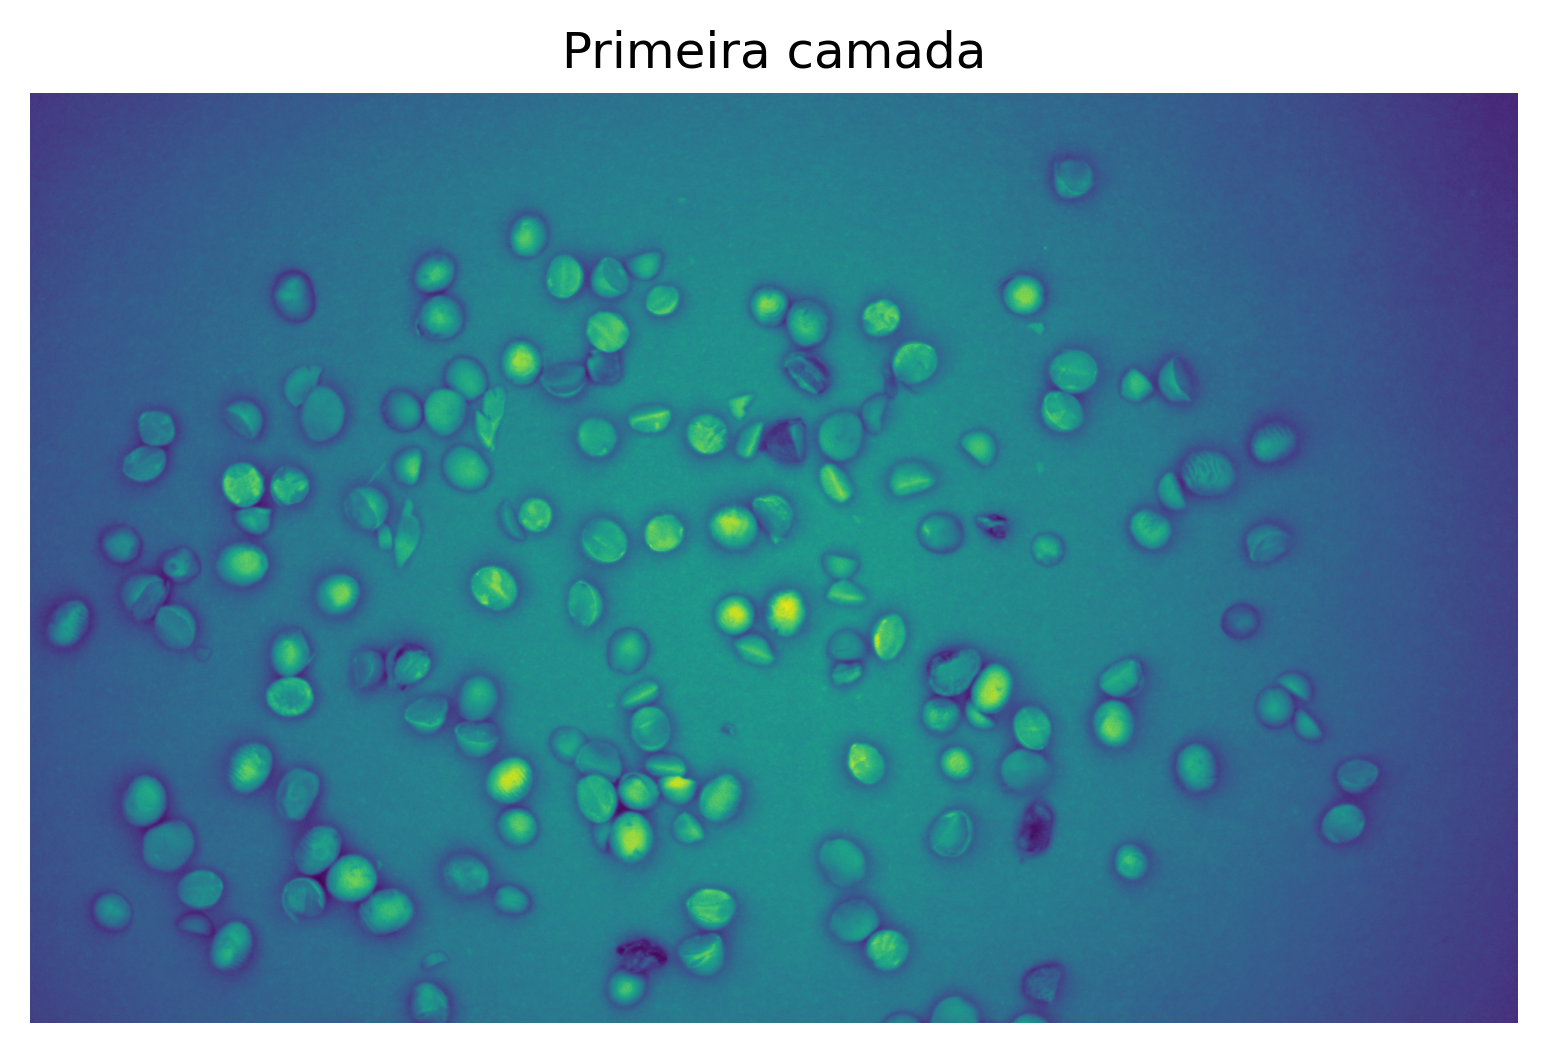

In [116]:
pasta = random.choice(os.listdir('soja'))
path = f'soja/{pasta}'
n_images = len(os.listdir(path))
index = random.randint(0, int(n_images/31)-1 )


first_image = skimage.io.imread(os.path.join(path, os.listdir(path)[0]))

plt.imshow(first_image)
plt.axis('off')
plt.title("Primeira camada")

plt.show()


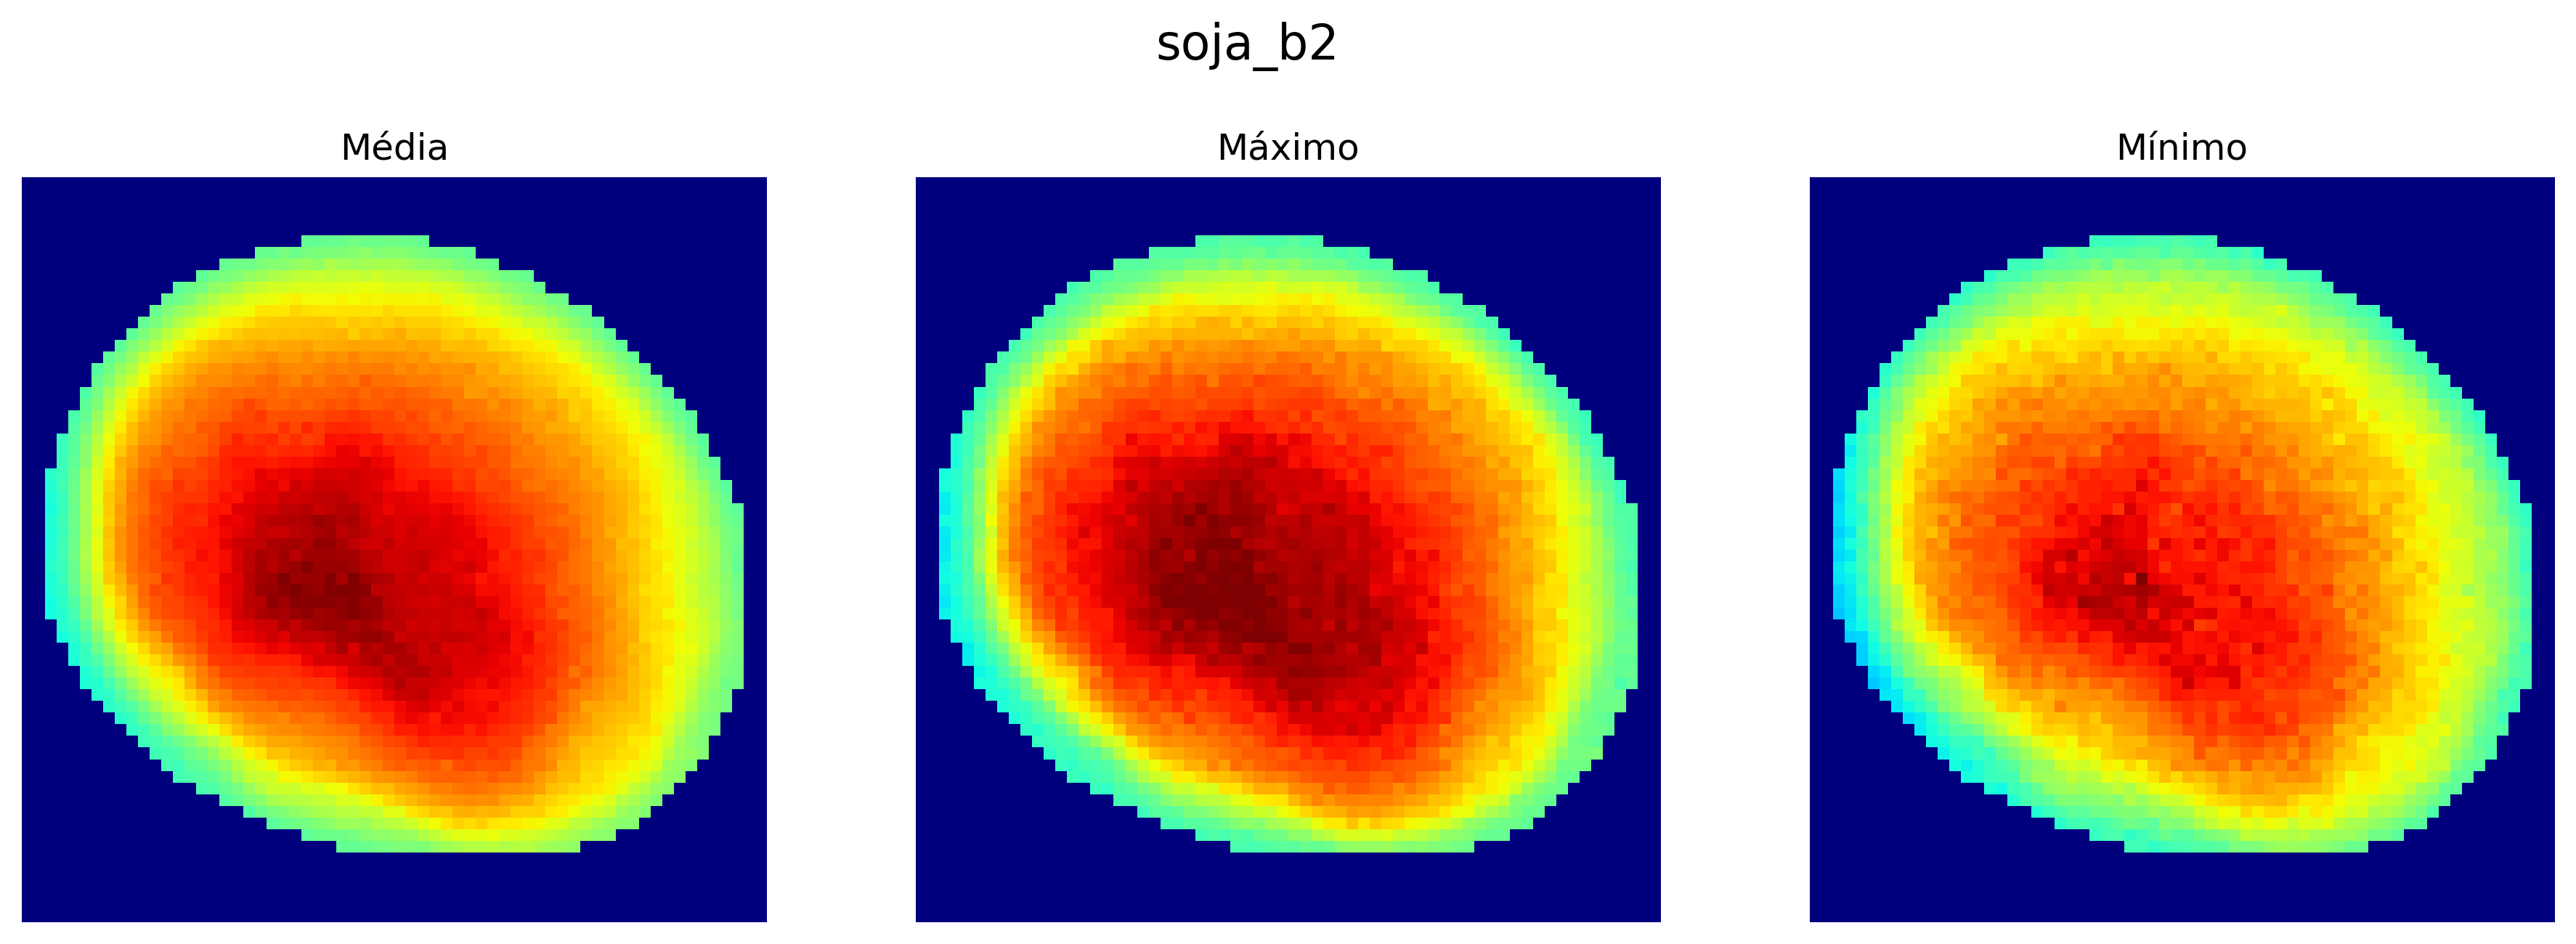

In [6]:
pasta = random.choice(os.listdir('_recortado'))
path = f'_recortado/{pasta}'
n_images = len(os.listdir(path))

index = random.randint(0, int(n_images/31)-1 )
first_image = skimage.io.imread(f'{path}/label_{index}_{0}.tiff')

# Percorre uma pasta de carregas as imagens 
images = []
for i in range(31):
    image = skimage.io.imread(f'{path}/label_{index}_{i}.tiff')
    images.append(image)

# Processo de fusão das camadas
fused_sum = np.zeros_like(images[0], dtype=np.float64) # Soma
fused_max = np.zeros_like(images[0], dtype=np.float64)  # Maximo
fused_min = np.full_like(images[0], np.inf, dtype=np.float64)  # Mínimo


for image in images:
    fused_sum += image.astype(np.float64)
    fused_max = np.maximum(fused_max, image.astype(np.float64))
    fused_min = np.minimum(fused_min, image.astype(np.float64))  

fused_avg = fused_sum / len(images)

# Normalizacao 
# Transforma a variação para ficar entre 0 e 1
# Exemplo: (1791 - 0) / (2804 - 0) = 0.63
# O processo de normalização serve para diminuir a variação entre os dados
# Melhorando a representação visual
fused_avg = (fused_avg - fused_avg.min()) / (fused_avg.max() - fused_avg.min())
fused_max = (fused_max - fused_max.min()) / (fused_max.max() - fused_max.min())
fused_min = (fused_min - fused_min.min()) / (fused_min.max() - fused_min.min())



plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(fused_sum, cmap='jet')
plt.axis('off')
plt.title("Média")

plt.subplot(1, 3, 2)
plt.imshow(fused_max, cmap='jet')
plt.axis('off')
plt.title("Máximo")

plt.subplot(1, 3, 3)
plt.imshow(fused_min, cmap='jet')
plt.axis('off')
plt.title("Mínimo")


# plt.subplot(1, 4, 4)
# plt.imshow(first_image, cmap='gray')
# plt.axis('off')
# plt.title("Primeira camada")

plt.suptitle(pasta, fontsize=16)

plt.savefig('image_fusion.png')
plt.show()
